In [1]:
import os
import sys

sys.path.append(os.path.join(os.getcwd(), ".."))

from vlmaps.utils.lseg_utils import get_lseg_feat
from vlmaps.utils.mapping_utils import (
    load_3d_map,
    save_3d_map,
    cvt_pose_vec2tf,
    load_depth_npy,
    depth2pc,
    transform_pc,
    base_pos2grid_id_3d,
    project_point,
    get_sim_cam_mat,
)

from vlmaps.lseg.modules.models.lseg_net import LSegEncNet

In [2]:
import torch
import os
from pathlib import Path
import torchvision.transforms as transforms
import gdown

def _init_lseg():
        crop_size = 480  # 480
        base_size = 640  # 520
        # if torch.cuda.is_available():
        #     self.device = "cuda"
        # elif torch.backends.mps.is_available():
        #     self.device = "mps"
        # else:
        #     self.device = "cpu"
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        lseg_model = LSegEncNet("", arch_option=0, block_depth=0, activation="lrelu", crop_size=crop_size)
        model_state_dict = lseg_model.state_dict()
        # checkpoint_dir = Path(__file__).resolve().parents[1] / "lseg" / "checkpoints"

        checkpoint_dir = Path(os.getcwd()).resolve().parents[1] / "lseg" / "checkpoints"
        map_config = {"model": "lseg-demo"}

        if "lseg" in map_config["model"]:
            # demo checkpoint from lseg repo
            if "demo" in map_config["model"]:
                checkpoint_path = checkpoint_dir / "demo_e200.ckpt"
            # official checkpoint from lseg repo
            else:
                checkpoint_path = checkpoint_dir / "fss_l16.ckpt"
        os.makedirs(checkpoint_dir, exist_ok=True)
        print(f"checkpoint path is : {checkpoint_path}")

        if not checkpoint_path.exists():
            print("Downloading LSeg checkpoint...")
            # the checkpoint is from official LSeg github repo
            # https://github.com/isl-org/lang-seg
            checkpoint_url = "https://drive.google.com/u/0/uc?id=1ayk6NXURI_vIPlym16f_RG3ffxBWHxvb"
            gdown.download(checkpoint_url, output=str(checkpoint_path))

        pretrained_state_dict = torch.load(checkpoint_path, map_location=device)
        pretrained_state_dict = {k.lstrip("net."): v for k, v in pretrained_state_dict["state_dict"].items()}
        model_state_dict.update(pretrained_state_dict)
        lseg_model.load_state_dict(pretrained_state_dict)

        lseg_model.eval()
        
        lseg_model = lseg_model.to(device)

        norm_mean = [0.5, 0.5, 0.5]
        norm_std = [0.5, 0.5, 0.5]
        lseg_transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
            ]
        )
        # self.clip_feat_dim = lseg_model.out_c
        return lseg_model, lseg_transform, crop_size, base_size, norm_mean, norm_std


seg_model, seg_transform, crop_size, base_size, norm_mean, norm_std = _init_lseg()

checkpoint path is : /home/r1-user/Projects/VLMaps/lseg/checkpoints/demo_e200.ckpt


/tmp/ipykernel_3289575/3370576680.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_state_dict = torch.load(checkpoint_path, map_location=device)


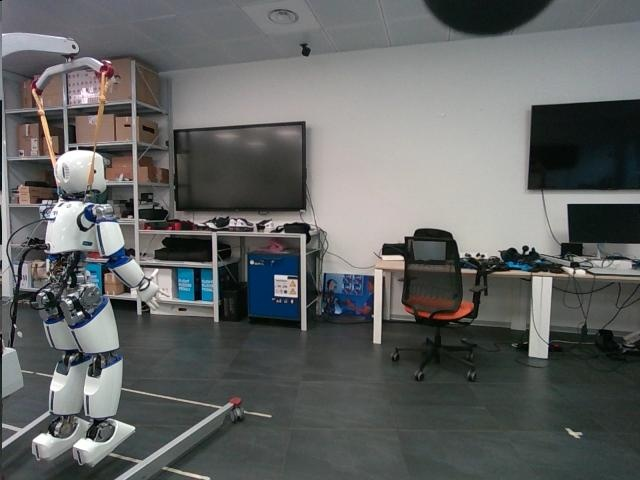

In [3]:
from PIL import Image

rgb = Image.open("images/25.png")
rgb

In [11]:
text_labels = ["robot", "other"]

# text_labels = ["chair", "ceiling", "robot", "tv",
#                 "table", "wall", "floor", "person",
#                 "laptop", "display", "shelf", "other"]

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
import numpy as np

rgb = np.array(rgb)

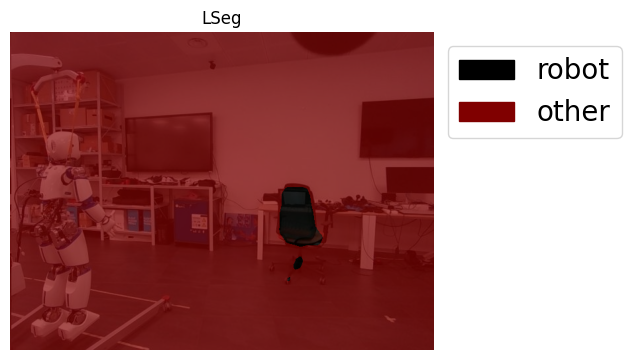

In [14]:
pix_feats = get_lseg_feat(
                seg_model, rgb, text_labels, seg_transform, device, crop_size, base_size, norm_mean, norm_std, vis=True
            )